In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path
import cv2
import numpy as np
import IPython
from skimage import io
import os

In [ ]:
!wget https://github.com/astaileyyoung/CineFace/raw/main/research/data/face_detection_yunet_2023mar.onnx

--2024-11-15 15:22:51--  https://github.com/astaileyyoung/CineFace/raw/main/research/data/face_detection_yunet_2023mar.onnx
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/astaileyyoung/CineFace/main/research/data/face_detection_yunet_2023mar.onnx [following]
--2024-11-15 15:22:52--  https://raw.githubusercontent.com/astaileyyoung/CineFace/main/research/data/face_detection_yunet_2023mar.onnx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 232589 (227K) [application/octet-stream]
Saving to: ‘face_detection_yunet_2023mar.onnx’

face_detection_yune 100%[===================>] 227.14K  --.-KB/s    in

In [ ]:
from pathlib import Path
import cv2
import numpy as np

class FaceDetectorYunet:
    def __init__(self, model_path='face_detection_yunet_2023mar.onnx', img_size=(300, 300), threshold=0.5):
        self.model_path = model_path
        self.img_size = img_size
        self.fd = cv2.FaceDetectorYN_create(str(model_path), "", img_size, score_threshold=threshold)

    def draw_faces(self, image, faces, draw_landmarks=False, show_confidence=False):
        for face in faces:
            color = (0, 0, 255)
            thickness = 2
            cv2.rectangle(image, (face['x1'], face['y1']), (face['x2'], face['y2']), color, thickness, cv2.LINE_AA)
            if draw_landmarks:
                landmarks = face['landmarks']
                for landmark in landmarks.values():
                    radius = 5
                    thickness = -1
                    cv2.circle(image, landmark, radius, color, thickness, cv2.LINE_AA)
            if show_confidence:
                confidence = "{:.2f}".format(face['confidence'])
                position = (face['x1'], face['y1'] - 10)
                font = cv2.FONT_HERSHEY_SIMPLEX
                scale = 0.5
                cv2.putText(image, confidence, position, font, scale, color, thickness, cv2.LINE_AA)
        return image

    def scale_coords(self, image, prediction):
        ih, iw = image.shape[:2]
        rw, rh = self.img_size
        a = np.array([
            (prediction['x1'], prediction['y1']),
            (prediction['x2'], prediction['y2'])
        ])
        b = np.array([iw / rw, ih / rh])
        c = a * b
        prediction['img_width'] = iw
        prediction['img_height'] = ih
        prediction['x1'] = int(c[0, 0].round())
        prediction['x2'] = int(c[1, 0].round())
        prediction['y1'] = int(c[0, 1].round())
        prediction['y2'] = int(c[1, 1].round())
        prediction['face_width'] = c[1, 0] - c[0, 0]
        prediction['face_height'] = c[1, 1] - c[0, 1]
        prediction['area'] = prediction['face_width'] * prediction['face_height']
        prediction['pct_of_frame'] = prediction['area'] / (prediction['img_width'] * prediction['img_height'])
        return prediction

    def detect(self, image):
        if isinstance(image, str):
            image = cv2.imread(image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img, self.img_size)
        self.fd.setInputSize(self.img_size)
        _, faces = self.fd.detect(img_resized)
        if faces is None:
            return None
        return self.parse_predictions(image, faces)

    def parse_predictions(self, image, faces):
        data = []
        for num, face in enumerate(faces):
            x1, y1, width, height = list(map(int, face[:4]))
            x2, y2 = x1 + width, y1 + height
            landmarks = face[4:len(face)-1].reshape((5, 2)).astype(int)
            positions = ['left_eye', 'right_eye', 'nose', 'right_mouth', 'left_mouth']
            landmarks_dict = {positions[i]: tuple(landmarks[i]) for i in range(5)}
            confidence = face[-1]
            datum = {'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2, 'face_num': num, 'landmarks': landmarks_dict, 'confidence': confidence, 'model': 'yunet'}
            data.append(self.scale_coords(image, datum))
        return data


def crop_faces(input_folder, output_folder):
    fd = FaceDetectorYunet(model_path='face_detection_yunet_2023mar.onnx')
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            face_filename = f"{os.path.splitext(filename)[0]}_face1.jpg"
            face_path = os.path.join(output_folder, face_filename)

            # Check if the cropped face already exists
            if os.path.exists(face_path):
                print(f"Cropped face is already saved at: {face_path}")
                continue

            img_path = os.path.join(input_folder, filename)
            img = cv2.imread(img_path)
            if img is None:
                continue
            faces = fd.detect(img)
            if faces:
                for i, face in enumerate(faces):
                    x1, y1, x2, y2 = face['x1'], face['y1'], face['x2'], face['y2']

                    # Check if the coordinates are valid
                    if 0 <= y1 < y2 <= img.shape[0] and 0 <= x1 < x2 <= img.shape[1]:
                        cropped_face = img[y1:y2, x1:x2]

                        # Check if cropped_face is not empty before saving
                        if cropped_face.size != 0:
                            face_filename = f"{os.path.splitext(filename)[0]}_face{i + 1}.jpg"
                            face_path = os.path.join(output_folder, face_filename)
                            cv2.imwrite(face_path, cropped_face)
                            print(f"Cropped face saved at: {face_path}")
                        else:
                            print(f"Warning: Empty cropped face for {filename}, skipping.")
                    else:
                        print(f"Warning: Invalid cropping coordinates for {filename}, skipping.")
            else:
                print(f"Warning: No face detected for {filename}, skipping")

def one_image_crop(image_path):
    fd = FaceDetectorYunet(model_path='face_detection_yunet_2023mar.onnx')
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read image at {image_path}")
        return
    faces = fd.detect(img)
    if faces:
        for i, face in enumerate(faces):
            x1, y1, x2, y2 = face['x1'], face['y1'], face['x2'], face['y2']
            cropped_face = img[y1:y2, x1:x2]
            show_image(cropped_face)
    else:
        print("No faces detected in the image.")

In [ ]:
def show_image(image):
    _, ret = cv2.imencode('.jpg', image)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

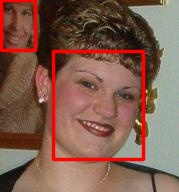

In [ ]:
img = io.imread('/content/drive/MyDrive/GENKI4k/Dataset/smile/file2070.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
faces = fd.detect(img)
if faces:
    fd.draw_faces(img, faces)
show_image(img)

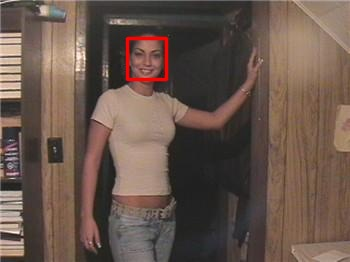

In [ ]:
img = io.imread('/content/drive/MyDrive/GENKI4k/Dataset/smile/file0003.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
faces = fd.detect(img)
if faces:
    fd.draw_faces(img, faces)
show_image(img)

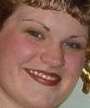

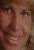

In [ ]:
image_path = ('/content/drive/MyDrive/GENKI4k/Dataset/smile/file2070.jpg')
one_image_crop(image_path)

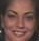

In [ ]:
image_path = '/content/drive/MyDrive/GENKI4k/Dataset/smile/file0003.jpg'
one_image_crop(image_path)

In [ ]:
# input_folder_1 = '/content/drive/MyDrive/GENKI4k/Dataset/smile'
# output_folder_1 = '/content/drive/MyDrive/GENKI4k/Dataset/cropped_smile'
# input_folder_2 = '/content/drive/MyDrive/GENKI4k/Dataset/non_smile'
# output_folder_2 = '/content/drive/MyDrive/GENKI4k/Dataset/cropped_non_smile'

# crop_faces(input_folder_1, output_folder_1)
# crop_faces(input_folder_2, output_folder_2)